# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [272]:
%%capture
!pip install pyspellchecker
!pip install vaderSentiment

In [273]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [274]:
import numpy as np
import os
import string
import re
from collections import Counter
from spellchecker import SpellChecker
import seaborn as sns

import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [275]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [276]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [277]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}", end="")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1   ---> 100 total reviews
Scraping page 2   ---> 200 total reviews
Scraping page 3   ---> 300 total reviews
Scraping page 4   ---> 400 total reviews
Scraping page 5   ---> 500 total reviews
Scraping page 6   ---> 600 total reviews
Scraping page 7   ---> 700 total reviews
Scraping page 8   ---> 800 total reviews
Scraping page 9   ---> 900 total reviews
Scraping page 10   ---> 1000 total reviews


In [278]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Check in was smooth enough. Bo...
1,✅ Trip Verified | Although transferring to thi...
2,✅ Trip Verified | We are extremely grateful ...
3,✅ Trip Verified | I had an appalling experie...
4,"Not Verified | Good points, the cabin crew, t..."


In [279]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/BA_reviews.csv")

In [280]:
print("No. of verified trips:", df.reviews.str.contains("✅ Trip Verified").sum().item())

No. of verified trips: 740


In [281]:
df.reviews = df.reviews.str.split("|", expand=True)[1]
df.head()

,reviews
0,Check in was smooth enough. Boarding was cha...
1,Although transferring to this flight through ...
2,We are extremely grateful to the crew of fl...
3,I had an appalling experience with British ...
4,"Good points, the cabin crew, they were helpf..."


In [282]:
df.iloc[0]['reviews']

"  Check in was smooth enough. Boarding was chaotic. We were herded through the gate only to be held for a seemingly never ending period of time outside next to the apron. We are BA silver members and noticed that despite business class being nearly empty we were not offered the chance to move up a class. The seat pocket in front of me full of the previous passenger's rubbish.  On arrival at Heathrow, our bags took a long time to reach the belt and plenty arrived before ours even though ours were supposed to be priority."

**Tasks**

- preprocessing
- sentiment analysis
- wordclouds

### Preprocessing

In [283]:
type(df.iloc[0]['reviews'])

str

In [284]:
# only working with alphabets
def just_alphabets(text):
    return re.sub('[^A-Za-z]+', ' ', text)

df = df.map(just_alphabets)
df.head()

,reviews
0,Check in was smooth enough Boarding was chaot...
1,Although transferring to this flight through ...
2,We are extremely grateful to the crew of flig...
3,I had an appalling experience with British Ai...
4,Good points the cabin crew they were helpful ...


In [285]:
# lower casing
df = df.map(lambda x: x.lower())

In [286]:
# removing URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df = df.map(remove_urls)

In [287]:
# removal of HTML tags
def remove_html_tags(text):
    tag_pattern = re.compile('<.*?>')
    return tag_pattern.sub(r'', text)

df = df.map(remove_html_tags)

In [288]:
# removing punctuation
PUNCTUATION = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION))

df = df.map(remove_punctuation)

In [289]:
# lemmatization with POS tagging
wordnet_map = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV,
}

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df = df.map(lemmatize_text)

In [290]:
# removing stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df = df.map(remove_stopwords)

In [291]:
df['reviews'][0]

'check smooth enough boarding chaotic herd gate hold seemingly never end period time outside next apron ba silver member notice despite business class nearly empty offer chance move class seat pocket front full previous passenger rubbish arrival heathrow bag take long time reach belt plenty arrive even though suppose priority'

In [292]:
# most frequent words
cntr = Counter()
for review in df['reviews'].values:
    for word in review.split():
        cntr[word] += 1

print("10 most frequent words")
cntr.most_common(10)

10 most frequent words


[('flight', 2299),
 ('ba', 1409),
 ('seat', 882),
 ('service', 783),
 ('time', 682),
 ('get', 666),
 ('hour', 625),
 ('good', 506),
 ('fly', 503),
 ('airline', 479)]

In [323]:
most_freq_string = []
for (word, count) in cntr.most_common(10):
    most_freq_string.append((word + ", ") * count)

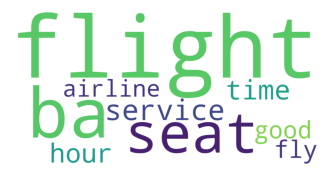

In [332]:
wordcloud = WordCloud(
    background_color='white',
    max_words=10,
    max_font_size=500,
    scale=5,
    collocations=False,
    random_state=42)

wordcloud = wordcloud.generate(str(most_freq_string))

fig = plt.figure(1, figsize=(4, 4))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [293]:
# FREQ_WORDS = set([word for (word, count) in cntr.most_common(10)])
# def remove_frequent(text):
#     return " ".join([word for word in text.split() if word not in FREQ_WORDS])

# df = df.map(remove_frequent)

In [294]:
# # removing most rare words
# print("10 most rare words")
# cntr.most_common()[:-(10 + 1):-1]

In [295]:
# RARE_WORDS = set([word for (word, count) in cntr.most_common() if count == 1]) # removing words with count == 1
# def remove_rare(text):
#     return " ".join([word for word in text.split() if word not in RARE_WORDS])

# df = df.map(remove_rare)

In [296]:
# # spelling correction
# spell = SpellChecker()
# def correct_spellings(text):
#     text = text.split()
#     corrected_text = []
#     misspelled_words = spell.unknown(text)

#     for word in text:
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join([word for word in corrected_text if word is not None])

# df = df.map(correct_spellings)

In [297]:
df['reviews'][0]

'check smooth enough boarding chaotic herd gate hold seemingly never end period time outside next apron ba silver member notice despite business class nearly empty offer chance move class seat pocket front full previous passenger rubbish arrival heathrow bag take long time reach belt plenty arrive even though suppose priority'

### Sentiment Analysis

In [298]:
# getting VADER's compound score
analyzer = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return analyzer.polarity_scores(text)['compound']

df['compound'] = df.map(get_compound_score)
df.head()

,reviews,compound
0,check smooth enough boarding chaotic herd gate...,-0.4404
1,although transfer flight heathrow budapest tak...,0.9689
2,extremely grateful crew flight ba cape town he...,0.8016
3,appalling experience british airway start try ...,-0.9748
4,good point cabin crew helpful professional mat...,0.9136


In [299]:
# classifying sentiments
def classify_sentiment(score, threshold=0.05):
    if score >= threshold:
        return "Positive"
    elif score < -threshold:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["compound"].map(classify_sentiment)
df.head()

,reviews,compound,sentiment
0,check smooth enough boarding chaotic herd gate...,-0.4404,Negative
1,although transfer flight heathrow budapest tak...,0.9689,Positive
2,extremely grateful crew flight ba cape town he...,0.8016,Positive
3,appalling experience british airway start try ...,-0.9748,Negative
4,good point cabin crew helpful professional mat...,0.9136,Positive


In [300]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/BA_final.csv")

In [301]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
Positive,0.570
Negative,0.417
Neutral,0.013


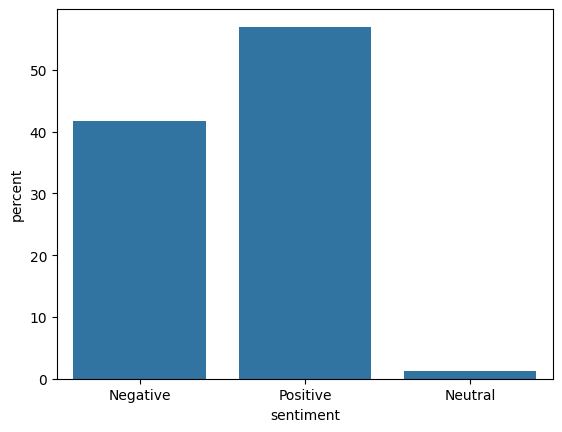

In [302]:
sns.countplot(df, x='sentiment', stat='percent');

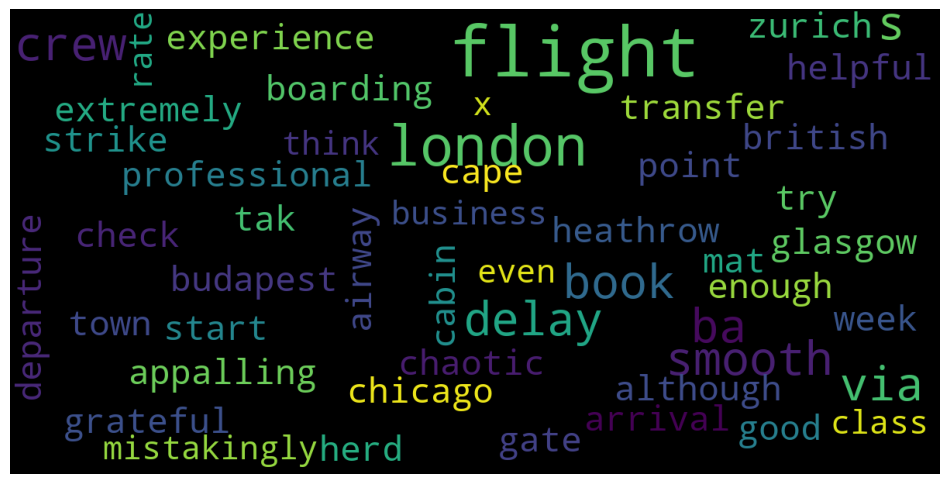

In [303]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=30,
    scale=3,
    random_state=42)

wordcloud = wordcloud.generate(str(df.reviews))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()